## Introduction

Credit scoring dùng để  tham khảo cho việc xét duyệt trước khi cho vay. Nhiệm vụ đặt ra xây dựng thuật toán ML phân loại hai nhóm khách hàng này.

## Description data

- loan_status: Trạng thái khoản vay (Bad nếu *Charged Off* hoặc *Default*,  Good nếu *Fully Paid*)  
- loan_amnt:   Tổng số tiền của khoản vay  
- int_rate: Lãi suất khoản vay  
- grade: Hạng công việc  
- emp_length: Thời gian làm việc  
- home_ownership: Loại hình sở hữu nhà  
- annual_inc: Tổng thu nhập hằng năm  
- term: Kì hạn vay

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
display(train.head())

,loan_status,loan_amnt,int_rate,grade,emp_length,home_ownership,annual_inc,term
0,Fully Paid,6000.0,9.76,B,4 years,RENT,33000.0,36 months
1,Fully Paid,19700.0,6.62,A,5 years,RENT,45000.0,36 months
2,Fully Paid,14000.0,6.03,A,< 1 year,MORTGAGE,75000.0,36 months
3,Fully Paid,21000.0,13.11,B,2 years,RENT,51000.0,36 months
4,Charged Off,4500.0,16.29,D,2 years,MORTGAGE,96000.0,36 months


In [4]:
display(test.head())

,loan_status,loan_amnt,int_rate,grade,emp_length,home_ownership,annual_inc,term
0,Fully Paid,9525.0,6.62,A,2 years,RENT,60000.0,36 months
1,Charged Off,17325.0,11.14,B,1 year,MORTGAGE,54000.0,36 months
2,Fully Paid,7000.0,8.49,A,5 years,RENT,118000.0,36 months
3,Fully Paid,10000.0,16.24,C,10+ years,MORTGAGE,150000.0,60 months
4,Fully Paid,9600.0,12.12,B,8 years,RENT,120000.0,36 months


## Evaluation

Đánh giá hiệu suất model dựa trên hệ số [Gini](https://en.wikipedia.org/wiki/Gini_coefficient)

# Phân tích đánh giá dữ liệu

In [5]:
print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (177933, 8)
Testing data shape:  (76257, 8)


Tập dữ liệu huấn luyện có 177933 hàng tương ứng là số  khoản vay và 8 cột thuộc tính, bao gồm **loan_status** là kết quả cần dự đoán. Tập test có 76257 bản ghi với các thuộc tính tương tự.

Tiến hành kiể m tra tương quan phân phối kết quả (nhãn **loan_status**) ở 2 tập dữ liệu.

In [6]:
train.loan_status.value_counts() / len(train)

Fully Paid     0.817347
Charged Off    0.177887
Default        0.004766
Name: loan_status, dtype: float64

In [7]:
test.loan_status.value_counts() / len(test)

Fully Paid     0.816843
Charged Off    0.178292
Default        0.004865
Name: loan_status, dtype: float64

Có thể nhận thấy kết quả ở hai tập là tương đương với nhau. Trong đó, tỉ lệ khách hàng tốt đều chiếm khoảng 81,7%, vượt trội so với tỉ lệ khách hàng xấu.
Ta sẽ tạo thêm một feature *target* với giá trị 0 đại diện cho giá trị *Fully Paid* và 1 tương ứng với *Default* hoặc *Charged Off*

In [8]:
train['target'] = np.where(train.loan_status == 'Fully Paid', 0, 1)
test['target'] = np.where(test.loan_status == 'Fully Paid', 0, 1)
train.head()

,loan_status,loan_amnt,int_rate,grade,emp_length,home_ownership,annual_inc,term,target
0,Fully Paid,6000.0,9.76,B,4 years,RENT,33000.0,36 months,0
1,Fully Paid,19700.0,6.62,A,5 years,RENT,45000.0,36 months,0
2,Fully Paid,14000.0,6.03,A,< 1 year,MORTGAGE,75000.0,36 months,0
3,Fully Paid,21000.0,13.11,B,2 years,RENT,51000.0,36 months,0
4,Charged Off,4500.0,16.29,D,2 years,MORTGAGE,96000.0,36 months,1


### Kiểm tra Missing values

In [9]:
train.isnull().sum()

loan_status          0
loan_amnt            0
int_rate             0
grade                0
emp_length        7013
home_ownership       0
annual_inc           0
term                 0
target               0
dtype: int64

Trong các thuộc tính, chỉ có **emp_length** có missing value.
Đây là thuộc tính thể hiện thời gian (kinh nghiệm) làm việc của người đi vay.
<!-- Ta sẽ thay thế các giá trị null bằng giá trị *Mode*. -->
Việc xử  lý mising value sẽ được đề cập ở phần dưới khi xử lý các thuộc tính rời rạc.

In [10]:
# emp_length_mode = train.emp_length.mode()
# train.fillna(emp_length_mode, )

#### Về kiểu dữ liệu của các thuộc tính

In [11]:
train.describe()

,loan_amnt,int_rate,annual_inc,target
count,177933.000000,177933.000000,1.779330e+05,177933.000000
mean,13582.523337,13.788521,7.245937e+04,0.182653
std,8138.463931,4.403421,5.596903e+04,0.386383
min,500.000000,5.320000,3.000000e+03,0.000000
25%,7300.000000,10.740000,4.500000e+04,0.000000
50%,12000.000000,13.570000,6.200000e+04,0.000000
75%,18375.000000,16.590000,8.700000e+04,0.000000
max,35000.000000,28.990000,7.141778e+06,1.000000


Ngoài trường kết quả, có ba thuộc tính nhận giá trị liên tục là loan_amt, int_rate và annual_inc. Bốn thuộc tính còn lại nhận giá trị rời rạc.
Bây giờ ta sẽ kiể m tra mối liên hệ giữa các thuộc tính đến kết quả khách hàng có khả năng thanh toán khoản vay hay không. Đối với các thuộc tính có giá trị số liên tục, sử dụng phân phối boxplot để biểu diễn.

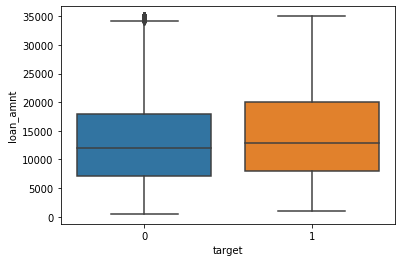

In [12]:
# boxplot for loan amount
sns.boxplot(train.target, train.loan_amnt)

Qua biểu đồ, có thể thấy, những khoản nợ xấu thường có giá trị lớn hơn nợ tốt. Tuy nhiên sự chênh lệch là không nhiều.

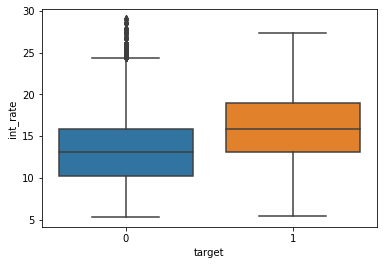

In [13]:
# boxplot for int rate
sns.boxplot(train.target, train.int_rate)

Ở biểu đồ của lãi suất, đã có sự chênh lệch rõ ràng hơn. Có thể thấy việc vay lãi suất cao sẽ dẫn tới việc trả nợ khó khăn hơn.

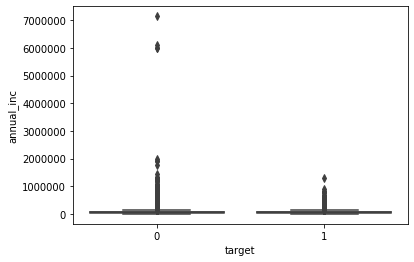

In [14]:
# boxplot for annual income
sns.boxplot(train.target, train.annual_inc)

Có thể thấy thu nhập của khách hàng có phân phối không chuẩn, có nhiều ngoại lệ (Outlier) với thu nhập cao hơn hẳn so với phần còn lại. Đây là những  ngoại lệ hợp lý khi đi đi cùng với thu nhập cao này là khả năng có thể trả nợ.
Để  khắc phục điều này, áp dụng *Log transform* sẽ giúp mở rộng các giá trị nằm trong phạm vi mật độ thấp và né hoặc giảm các giá trị trong phạm vi mật độ cao.

,loan_status,loan_amnt,int_rate,grade,emp_length,home_ownership,annual_inc,term,target,annual_inc_log
0,Fully Paid,6000.0,9.76,B,4 years,RENT,33000.0,36 months,0,10.404293
1,Fully Paid,19700.0,6.62,A,5 years,RENT,45000.0,36 months,0,10.714440
2,Fully Paid,14000.0,6.03,A,< 1 year,MORTGAGE,75000.0,36 months,0,11.225257
3,Fully Paid,21000.0,13.11,B,2 years,RENT,51000.0,36 months,0,10.839601
4,Charged Off,4500.0,16.29,D,2 years,MORTGAGE,96000.0,36 months,1,11.472114


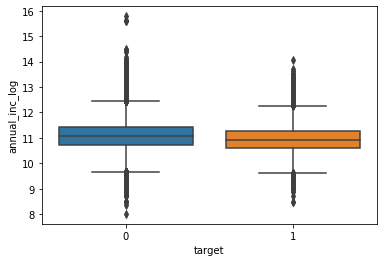

In [15]:
train['annual_inc_log'] = np.log(1 + train.annual_inc) # tạo thêm feature annual_inc_log cho tập train
test['annual_inc_log'] = np.log(1 + test.annual_inc) # tạo thêm feature annual_inc_log cho tập train

display(train.head())
sns.boxplot(train.target, train.annual_inc_log)

Biểu đồ cũng cho thấy phần lớn những khách hàng xấu thường có thu nhập thấp hơn (nhưng không đáng kể) so với khách hàng tốt.

## Categorical features.

Với các thuộc tính rời rạc, trước hết kiểm tra số lượng của mỗi giá trị. 

In [16]:
# đếm số lượng các giá trị biến grade - các loại hạng công việc và tỉ lệ
train.grade.value_counts() / len(train)

B    0.299000
C    0.258389
A    0.166029
D    0.161443
E    0.077130
F    0.030478
G    0.007531
Name: grade, dtype: float64

In [17]:
# đếm số lượng các giá trị emp_length - phân loại kinh nghiệm làm việc và tỉ lệ
train.emp_length.value_counts(dropna=False) / len(train)

10+ years    0.303198
2 years      0.092923
< 1 year     0.082953
3 years      0.080317
5 years      0.071027
1 year       0.067126
4 years      0.064389
6 years      0.058050
7 years      0.055622
8 years      0.047237
NaN          0.039414
9 years      0.037745
Name: emp_length, dtype: float64

Với các giá trị mising của **emp_length**, ta sẽ impute bằng giá trị mode (10+ years)

In [18]:
# chọn giá trị mode
mode_emp_length = '10+ years'
train.fillna(value=mode_emp_length, inplace=True)
# kiểm tra lại emp_length sau khi impute
train.emp_length.value_counts(dropna=False) / len(train)

10+ years    0.342612
2 years      0.092923
< 1 year     0.082953
3 years      0.080317
5 years      0.071027
1 year       0.067126
4 years      0.064389
6 years      0.058050
7 years      0.055622
8 years      0.047237
9 years      0.037745
Name: emp_length, dtype: float64

In [19]:
# đếm số lượng các giá trị biến home_ownership - các loại hình sợ hữu nhà và tỉ lệ
train.home_ownership.value_counts() / len(train)

MORTGAGE    0.494253
RENT        0.419006
OWN         0.086021
OTHER       0.000523
NONE        0.000191
ANY         0.000006
Name: home_ownership, dtype: float64

In [20]:
# đếm số loại thời hạn trả nợ
train.term.value_counts() / len(train)

 36 months    0.775157
 60 months    0.224843
Name: term, dtype: float64

Trong số bốn thuộc tính trên, chỉ có **term** là chỉ nhận hai giá trị 36 tháng và 60 tháng, ta sẽ encode bằng LabelEncoder của thư viện Scikit-learn. Các thuộc tính còn lại đều có (loại) giá trị nhiều hơn. Để xử lý các thuộc tính này, ta sẽ sử dụng kỹ thuật *One-hot encoding* với pandas.get_dummies(). 

In [21]:
# train.drop(columns=['emp_length'], inplace=True)
# test.drop(columns=['emp_length'], inplace=True)

#### Encoding for *term*

Kiểm tra phân phối của **target** với thuộc tính **term**

In [22]:
term_target_df = pd.crosstab(train.term, train.target, margins=True, margins_name='Total')
# term_target_df.columns = ['Good', 'Bad']
term_target_df['Good_per'] = term_target_df[0] / term_target_df.Total
term_target_df['Bad_per'] = term_target_df[1] / term_target_df.Total

In [23]:
term_target_df

target,0,1,Total,Good_per,Bad_per
term,,,,,
36 months,117120,20806,137926,0.849151,0.150849
60 months,28313,11694,40007,0.707701,0.292299
Total,145433,32500,177933,0.817347,0.182653


Dễ dàng nhận thấy số lượng khoản vay thời hạn 36 tháng là vượt trội (hơn 77% so với 23% của khoản vay 60 thangs). Đáng chú ý là hầu hết khoản vay 36 tháng đều là nợ tốt, còn 60 tháng là ngược lại.

Bây giờ ta sẽ tiến hành encode các giá trị của **term** với LabelEncoder

In [24]:
# Create a label encoder object
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in train:
    if train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(train[col].unique())) <= 2:
            # Train on the training data
            le.fit(train[col])
            # Transform both training and testing data
            train[col] = le.transform(train[col])
            test[col] = le.transform(test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

/home/ta/anaconda3/envs/dyno/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence


1 columns were label encoded.


In [25]:
train

,loan_status,loan_amnt,int_rate,grade,emp_length,home_ownership,annual_inc,term,target,annual_inc_log
0,Fully Paid,6000.0,9.76,B,4 years,RENT,33000.0,0,0,10.404293
1,Fully Paid,19700.0,6.62,A,5 years,RENT,45000.0,0,0,10.714440
2,Fully Paid,14000.0,6.03,A,< 1 year,MORTGAGE,75000.0,0,0,11.225257
3,Fully Paid,21000.0,13.11,B,2 years,RENT,51000.0,0,0,10.839601
4,Charged Off,4500.0,16.29,D,2 years,MORTGAGE,96000.0,0,1,11.472114
...,...,...,...,...,...,...,...,...,...,...
177928,Fully Paid,4750.0,10.16,B,10+ years,MORTGAGE,63000.0,0,0,11.050906
177929,Fully Paid,10000.0,9.17,B,10+ years,RENT,70600.0,0,0,11.164800
177930,Fully Paid,9000.0,14.33,C,10+ years,RENT,63000.0,0,0,11.050906
177931,Fully Paid,19800.0,22.99,F,6 years,MORTGAGE,100000.0,1,0,11.512935


In [26]:
test

,loan_status,loan_amnt,int_rate,grade,emp_length,home_ownership,annual_inc,term,target,annual_inc_log
0,Fully Paid,9525.0,6.62,A,2 years,RENT,60000.0,0,0,11.002117
1,Charged Off,17325.0,11.14,B,1 year,MORTGAGE,54000.0,0,1,10.896758
2,Fully Paid,7000.0,8.49,A,5 years,RENT,118000.0,0,0,11.678448
3,Fully Paid,10000.0,16.24,C,10+ years,MORTGAGE,150000.0,1,0,11.918397
4,Fully Paid,9600.0,12.12,B,8 years,RENT,120000.0,0,0,11.695255
...,...,...,...,...,...,...,...,...,...,...
76252,Fully Paid,9175.0,15.59,D,NaN,MORTGAGE,23000.0,0,0,10.043293
76253,Fully Paid,6400.0,12.12,B,4 years,RENT,85000.0,0,0,11.350418
76254,Fully Paid,25000.0,13.11,B,9 years,MORTGAGE,65000.0,1,0,11.082158
76255,Fully Paid,5375.0,17.77,D,4 years,MORTGAGE,20000.0,0,0,9.903538


##### Encoding for home_ownership, grade

In [27]:
# one-hot encoding of categorical variables
train = pd.get_dummies(train)
test = pd.get_dummies(test)
train

,loan_amnt,int_rate,annual_inc,term,target,annual_inc_log,loan_status_Charged Off,loan_status_Default,loan_status_Fully Paid,grade_A,...,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
0,6000.0,9.76,33000.0,0,0,10.404293,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,19700.0,6.62,45000.0,0,0,10.714440,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
2,14000.0,6.03,75000.0,0,0,11.225257,0,0,1,1,...,0,0,0,1,0,1,0,0,0,0
3,21000.0,13.11,51000.0,0,0,10.839601,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,4500.0,16.29,96000.0,0,1,11.472114,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177928,4750.0,10.16,63000.0,0,0,11.050906,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
177929,10000.0,9.17,70600.0,0,0,11.164800,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
177930,9000.0,14.33,63000.0,0,0,11.050906,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
177931,19800.0,22.99,100000.0,1,0,11.512935,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [28]:
test

,loan_amnt,int_rate,annual_inc,term,target,annual_inc_log,loan_status_Charged Off,loan_status_Default,loan_status_Fully Paid,grade_A,...,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
0,9525.0,6.62,60000.0,0,0,11.002117,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
1,17325.0,11.14,54000.0,0,1,10.896758,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,7000.0,8.49,118000.0,0,0,11.678448,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
3,10000.0,16.24,150000.0,1,0,11.918397,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,9600.0,12.12,120000.0,0,0,11.695255,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76252,9175.0,15.59,23000.0,0,0,10.043293,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
76253,6400.0,12.12,85000.0,0,0,11.350418,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
76254,25000.0,13.11,65000.0,1,0,11.082158,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
76255,5375.0,17.77,20000.0,0,0,9.903538,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


Hot-encoding đã sinh ra các feature mới với giá trị 0 và 1 đại diện cho các giá trị trong **grade** và **home_ownership**.
Tuy nhiên, nếu trong tập test và tập train không đồng nhấ t về các giá trị, thì số cột mới sinh ra sẽ khác nhau ở hai tập dữ liệu. Ta sẽ kiểm tra điều này

In [29]:
print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (177933, 33)
Testing Features shape:  (76257, 32)


Tập train hiện có 33 cột, trong khi đó tập test chỉ có 32. Vì vậy, cần có một vước đồng bộ tập features giữa hai tập dữ liệu bằng cách loại bỏ đi những feature có trong train mà không có trong test.

In [30]:
# Align the training and testing data, keep only columns present in both dataframes
train, test = train.align(test, join = 'inner', axis = 1)

print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (177933, 32)
Testing Features shape:  (76257, 32)


## Feature Engineering

Ta sẽ thử tạo ra các feature mới từ những domain feature có sẵn.
-    **loan_income_percentage**: tỉ lệ giữa khoản nợ và thu nhập hàng năm của người vay
-    **annual_interest**: lãi suất hàng năm
-    **ann_int_income_percentage**: tỉ lệ giữa lãi và thu nhập hàng năm của người vay
    

In [56]:
# copy train and test data
train_domain = train.copy()
test_domain = test.copy()

# generate new features for train data
train_domain['loan_income_percentage'] = train_domain['loan_amnt'] / train_domain['annual_inc']
train_domain['annual_interest'] = train_domain['int_rate'] * train_domain["loan_amnt"]
train_domain['ann_int_income_percentage'] = train_domain['annual_interest'] / train_domain['annual_inc']

In [57]:
# generate new features for test data
test_domain['loan_income_percentage'] = test_domain['loan_amnt'] / test_domain['annual_inc']
test_domain['annual_interest'] = test_domain['int_rate'] * test_domain["loan_amnt"]
test_domain['ann_int_income_percentage'] = test_domain['annual_interest'] / test_domain['annual_inc']

# Modeling

Sau khi đã hoàn thành encoding các feature, đồng bộ giữa hai tập dữ liệu train và test, ta sẽ áp dụng machine learning model vào các tập dữ liệu.
Ở đây, LinearRegression là thuật toán được chọn.

In [31]:
# prepare data for model
Y_train = train.target
X_train = train.drop(columns=['target'])
Y_test = test.target
X_test = test.drop(columns=['target'])

In [32]:
from sklearn.linear_model import LogisticRegression
# Make the model
clf = LogisticRegression()
# train on training set
clf.fit(X_train, Y_train)
# make prediction
Y_score = clf.predict_proba(X_test)[:,1]

/home/ta/anaconda3/envs/dyno/lib/python3.7/site-packages/sklearn/model_selection/_split.py:18: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/home/ta/anaconda3/envs/dyno/lib/python3.7/site-packages/sklearn/model_selection/_search.py:16: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, namedtuple, defaultdict, Sequence


In [52]:
Y_score

array([0.18762961, 0.26035378, 0.08421534, ..., 0.2631632 , 0.26302615,
       0.09744434])

Ta sẽ đánh giá hiệu suất của model bằng hệ số Gini, được tính theo công thức:
    Gini = 2 * AUC - 1
với AUC (Area Under the Curve) có thể  tính qua sklearn metrics.

In [34]:
from sklearn import metrics
# compute the roc_auc
roc  = metrics.roc_auc_score(Y_test, Y_score)
# compute gini
gini = 2 * roc -1
gini

0.34562235045170975

## Model Tuning

#### Update model
Ta thử cải thiện hiệu suất bằng cách sử dụng model Random Forest với số cây bằng 100.

In [35]:
from sklearn.ensemble import RandomForestClassifier

# create the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

/home/ta/anaconda3/envs/dyno/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [38]:
random_forest.fit(X_train, Y_train)

# # Extract feature importances
# feature_importance_values = random_forest.feature_importances_
# feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
predictions = random_forest.predict_proba(X_test)[:,1]

#gini score for random forest
# gini_rf = metrics.roc_auc_score(Y_test, predictions)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished


In [53]:
roc_rf = metrics.roc_auc_score(Y_test, predictions)

In [54]:
gini_rf = 2 * roc_rf - 1

1.0

#### Sử dụng engineered features

In [58]:
X_train_domain = train_domain.drop(columns='target')
X_test_domain = test_domain.drop(columns='target')

#create clf using domain_feature
clf_domain = LogisticRegression()
clf_domain.fit(X_train_domain, Y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [61]:
#make prediction
Y_score_domain = clf_domain.predict_proba(X_test_domain)[:,1]

In [62]:
#compute the roc_auc
roc_domain = metrics.roc_auc_score(Y_test, Y_score_domain)
gini = 2 * roc_domain -1
gini

0.3197261696701936